## Tonale Winter School on Cosmology 2022 
# Tutorial on Gravitational Lensing

## Exercise 4: Time delays

In this tutorial, you will play with time delay surfaces. More specifically, you will build a sort of app to visualize the time delay surfaces of circular and elliptical lenses.

>**Warning**: it is important that you execute the cells following the order given in the Notebook. If you execute a cell changing the value of a variable and then go back to some previous cell in the Notebook, the variable value will not change!

Let's begin with importing some useful packages:

In [1]:
# import some useful packages and 

import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from astropy.cosmology import FlatLambdaCDM
from PIL import Image
fontsize = 15 # set the font size for labels in the plots

We define a Field-of-View and decide the number of pixels on the time delay surfaces:

In [2]:
FOV = 5.0 # the Field-of-View will be FOVxFOV arcsec 
npix= 512 # the number of pixels in the maps will be (npix x npix)

We build a mesh (`theta1`,`theta2`) on the lens plane covering the FOV:

In [3]:
theta = np.linspace(-FOV/2., FOV/2, npix)
theta1, theta2 = np.meshgrid(theta,theta)

### Geometrical time delay

>**TASK**: Your first task is to write a function that compute the map of the geometrical time delay:
> 
> $
>\tau_{geom}(\vec\theta) = \frac{1}{2}(\vec\theta-\vec\beta)^2
>$
>
> You just need to fill the code below with what is missing. **For the moment, neglect the cosmology dependent factor $\frac{1+z_L}{c}\frac{D_LD_S}{D_{LS}}$**.

In [4]:
def geom_tdelay(theta1,theta2,beta1=0.0,beta2=0.0):
    """
    Function to calculate the geometrical time delay:
    inputs: 
    - theta1, theta2 :: mesh of coordinates where the time delay will be evaluated
    - beta1, beta2 :: unlensed source coordinates
    output: 
    - geometrical time delay surface  
    """
    #TODO: write the geometrical time delay as return value of this function 
    return ...

You can use the function `show_tdsurface` to visualize the geometrical time delay. Change the source position as you like, but keep it inside the FOV. 

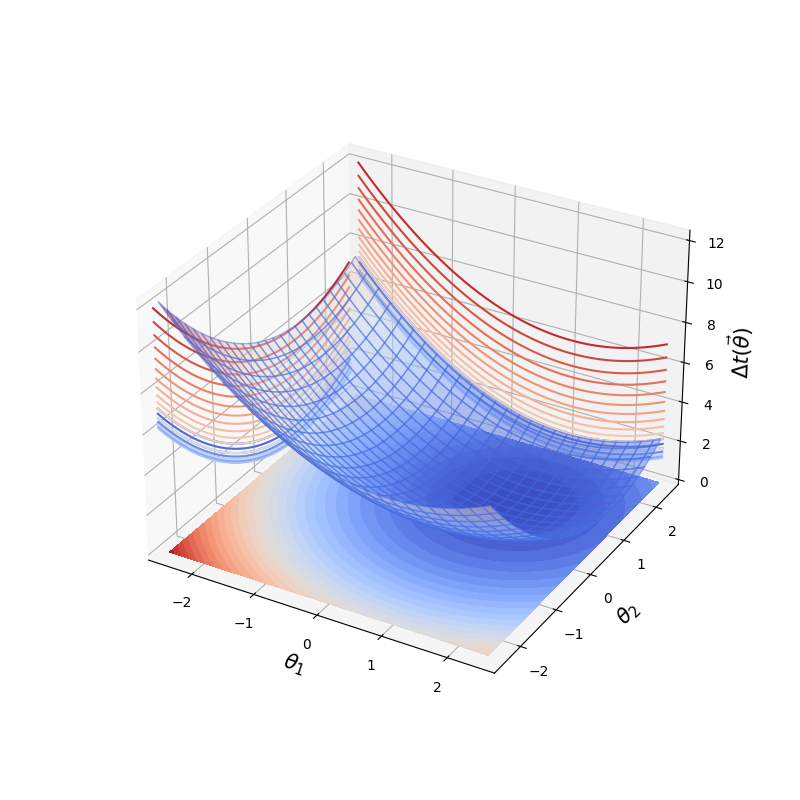

In [5]:
def show_tdsurface(surf,theta1,theta2,ax3d,alpha=0.5,cmap='cubehelix',fontsize=20,rstride=20,cstride=20,levels=30,buf=1.0):
    """
    Function to display the time delay surface in a 3D plot
    inputs:
    - surf: the surface to be displayed
    - theta1,theta2: the coordinates where the surface was evaluated
    - ax3d: the 3D axes where the plot will be drawn
    - alpha: the transparency of the surface
    - cmap: the color map used
    - fontsize: the label fontsize
    - rstride: downsampling stride along rows
    - cstride: downsampling stride along columns
    - levels: list of contour levels or their number
    - buf: buffer around the plot

    output: the plot!
    """
    surf=surf-np.amin(surf)
    ax3d.plot_surface(theta1,theta2,surf,cmap=cmap,alpha=0.5,edgecolor='royalblue',antialiased=True,rstride=rstride,cstride=cstride)
    cset = ax3d.contourf(theta1,theta2,surf,zdir='z',offset=np.amin(surf),cmap=cmap,levels=levels)
    cset = ax3d.contour(theta1,theta2,surf,zdir='x',offset=np.amin(theta1)-buf,cmap=cmap.reversed(),levels=levels)#, levels=[0])
    cset = ax3d.contour(theta1,theta2,surf,zdir='y',offset=-np.amin(theta2)+buf,cmap=cmap.reversed(),levels=levels)#, levels=[0])
    ax3d.set_xlabel(r'$\theta_1$',fontsize=fontsize)
    ax3d.set_ylabel(r'$\theta_2$',fontsize=fontsize)
    ax3d.set_zlabel(r'$\Delta t(\vec\theta)$',fontsize=fontsize)
    ax3d.set_xlim3d(np.amin(theta1)-buf, np.amax(theta1)+buf)
    ax3d.set_ylim3d(np.amin(theta2)-buf, np.amax(theta2)+buf)
    ax3d.set_aspect('auto')
    #ax3d.autoscale()


geomtd = geom_tdelay(theta1,theta2,beta1=1.0,beta2=1.0)


fig = plt.figure(figsize=(8,8))
ax3d = fig.add_subplot(111, projection='3d')
show_tdsurface(geomtd,theta1,theta2,ax3d=ax3d,cmap=cm.coolwarm,fontsize=fontsize,buf=0.1)   



The function displays the geometrical time delay as a surface. This surface is a paraboloid with a minimum at $\vec\beta=(\beta_1,\beta_2)$. By setting the `levels` option to a value or to a list of values, you can define filled contour profiles that will be projected on the 'walls' of the graph. If the `widget` mode is working on your computer, you should be able to rotate the plot using your mouse.

### Gravitational time delay

As part of the tutorial package, you downloaded a module called `lensmodel`, which contains some classes useful to work with lens models. In this example, we use the Softened Isothermal Elliptical (SIE) model [(Oguri 2022)](https://github.com/oguri/glafic2/blob/main/manual/man_glafic.pdf). The convergence of this lens is given by
$$
\kappa(\vec\theta) = \frac{b_{SIE}(q)}{2\sqrt{s^2(q)+\theta_1^2+\theta_2^2/q^2}}
$$
where $q$ is the axis ratio. The normalization $b_{SIE}$ is related to the lens velocity dispersion $\sigma$, since 
$$
b_{SIE}(1)=4\pi\left(\frac{\sigma}{c}\right)^2\frac{D_{LS}}{D_S}.
$$
Instead, the function $s(q)$ is related to the core radius $\theta_c$, since 
$$
s(1) = \theta_c.
$$
The scaling of $b_{SIE}$ and $s$ with $q$ is given by 
$$
\frac{b_{SIE}(q)}{b_{SIE}(1)} = \frac{s(q)}{s(1)}=\frac{1}{\sqrt(q)}.
$$
The peculiarity of this lens model is that it has a singular isothermal profile $\kappa(\theta)\propto \theta^{-1}$ for $\theta_c=0$. In the presence of a core radius $\theta_c>0$, the singularity is removed. Of course for $q=1$ the model becomes circular. In the implementation that you will find in the module `lensmodel`, the rotation of the lens by an angle `pa` counter-clockwise with respect to the axis $\theta_1$ has been implemented.

First, we define a cosmological model. We use the [`FlatLambdaCDM`](https://docs.astropy.org/en/stable/api/astropy.cosmology.FlatLambdaCDM.html) class from the `astropy.cosmology` module and set $\Omega_m=0.3$ and $H_0=72$ km $s^{-1}$ $\mathrm{Mpc}^{-1}$.




In [6]:
from lensmodels import *
co = FlatLambdaCDM(H0=70.0, Om0=0.3)

To create an instance `lens` of the SIE lens, you need to specify the lens parameters (`thetac`,`sigma0`,`q`,`pa`) and position (`x1`,`x2`) in a dictionary that is then passed to the class `__init__` function together with the cosmological model `co`. The dictionary contains also the lens and source redshift needed to compute the angular diameter distances between observer, lens, and source. For example, to create a mock galaxy-scale lens, you could run the following code:

In [7]:
zl = 0.5
zs = 2.0

kwargs = {'zl': zl,
          'zs': zs,
          'sigma0': 300.0,
          'q': 0.6,
          'pa': 0.0,
          'theta_c': 0.01,
          'x1': 0.0,
          'x2': 0.0}

lens = sie(co,**kwargs)
lens.setGrid(theta=theta)

when the function `setGrid` is called, all the lensing maps are automatically created. The coordinates of the grid points are set by the vector `theta`. They are in the range `[-theta/2,theta/2]` along both the $\theta_1$ and $\theta_2$ axes. The lensing potential map is stored in the `pot` attribute of the `lens` object. Thus, you can plot the lensing potential as follows: 

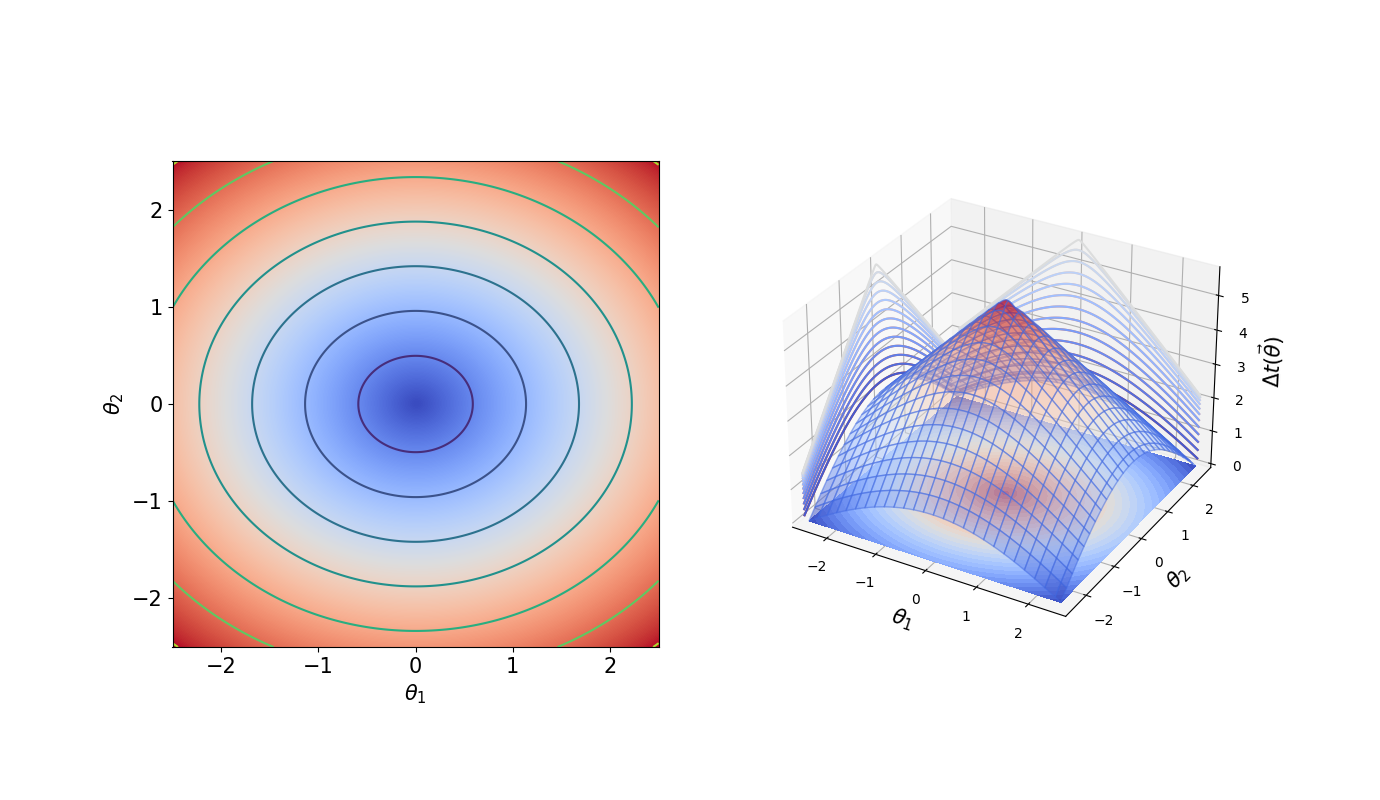

In [8]:
#%matplotlib inline
%matplotlib widget

fig = plt.figure(figsize=(13.8,8))
ax=fig.add_subplot(121)
ax.imshow(lens.pot,extent=[-FOV/2.,FOV/2.,-FOV/2.,FOV/2.],cmap=cm.coolwarm) 
ax.contour(lens.pot,extent=[-FOV/2.,FOV/2.,-FOV/2.,FOV/2.])
ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

ax3d = fig.add_subplot(122, projection='3d')
show_tdsurface(-lens.pot,theta1,theta2,ax3d=ax3d,cmap=cm.coolwarm,fontsize=fontsize,levels=30,alpha=0.3,buf=0.1)

The panel on the left shows the lensing potential map. On the right, you can see the gravitational time delay surface
$$
\tau_{grav}(\vec\theta)=-\hat{\Psi}(\vec\theta) .
$$

>**TASK**: try to modify the lens parameters to see how the lensing potential and the gravitational time delay change.

### Time delay surface

The time delay surface is the sum of the geometrical and gravitational time delays. Actually, so far you only calculated the two terms of the Fermat potential
$$
\tau(\vec\theta) = \frac{1}{2}(\vec\theta-\vec\beta)^2-\hat\Psi(\vec\theta).
$$

The time delay is
$$
\Delta t(\vec\theta)=\frac{1+z_L}{c}\frac{D_LD_S}{D_{LS}}\tau(\vec\theta).
$$
The cosmology-dependent factor that you need to multiply by $\tau(\vec\theta)$ is stored in `lens` as the attribute `conv_fact_time.value`.

>**TASK**: complete the code below to display the time delay surface for a given combination of source and SIE lens.


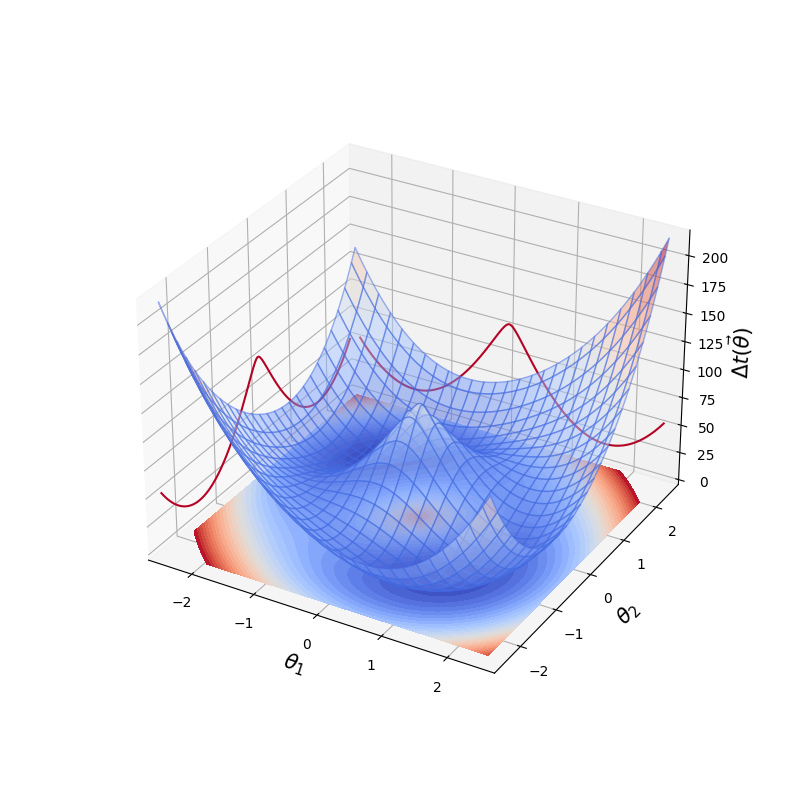

In [9]:
%matplotlib widget

# TODO: compute the geometrical time delay \tau_{geom} for a given source
beta1 = ...
beta2 = ...
geomtd = ...

# TODO: compute the gravitational time delay \tau_{grav} for a given SIE lens

zl = 0.5
zs = 2.0

...

gravtd = ...

# TODO: sum the two components of the Fermat potential and multiply by lens.conv_fact_time
td  = ...

# define some contour levels
max_td = 1.5*((-lens.pot).max()-td.min())

if max_td>0:
    levels = np.linspace(0,max_td,30)
else:
    levels=30

# define some contour levels
max_td = 1.5*((-lens.pot).max()-td.min())

if max_td>0:
    levels = np.linspace(0,max_td,30)
else:
    levels=30
    
# display the time delay surface
fig = plt.figure(figsize=(8,8))
ax3d = fig.add_subplot(111, projection='3d')
show_tdsurface(td,theta1,theta2,ax3d=ax3d,cmap=cm.coolwarm,fontsize=fontsize,levels=levels,alpha=0.3,buf=0.1)

>**TASK**: How many images will the lens produce for the source at the position you have chosen?

>**TASK**: Keep the lens at the center of the FOV. Consider several source positions and discuss how the time delay surface changes.

>**TASK**: Set $q=0$ and $\sigma=300$ km $s^{-1}$ (try several values of $\theta_c$). If $\vec\beta=0$, how do the the source images look like?

>**TASK**: Set $q=0.6$ and $\sigma=300$ km $s^{-1}$. If $\vec\beta=0$, how do the the source images look like?

TODO: write your answers here.

### Time delay surface and critical lines

It is interesting to compare the locations of minima, maxima, and saddle points of the time delay surface with the lens critical lines. The SIE class in the `lensmodel` module contains functions to compute the lens critical lines and caustics. For example, to find the critical lines of the lens defined above, you just need to type the following commands: 

In [10]:
tancl = lens.tancl()
radcl = lens.radcl()

print (type(tancl))
print (tancl[0])

<class 'list'>
[[1.7074364  0.97970872]
 [1.70697694 0.98336595]
 [1.70566128 0.99315068]
 ...
 [1.7093525  0.96379648]
 [1.70820785 0.97358121]
 [1.7074364  0.97970872]]


Both `tancl` and `radcl` are lists of tangential and radial critical lines respectively. Each critical line is a list of (x,y) coordinates of critical points in arcsec with respect to the center of the coordinate system $\theta_1,\theta_2$ chosen before. 

`lensmodel.sie` also contains the function `crit2cau` to map the critical lines into the corresponding caustics. 

The following code creates a plot with two panels. The left panel shows the lens caustics in black. The red point is the source position (used to compute the geometrical time delay). The right panel shows the time delay contours projected on the $\theta_1,\theta_2$ plane. It also shows the critical lines as dashed black lines.

>**TASK**: how are the minima, maxima, and saddle points of the time delay surface located with respect to the critical lines?

>**TASK**: modify the code below to color the radial and tangential critical lines differently. Answer the previous question in light of this additional information.

Text(0, 0.5, '$\\theta_2$')

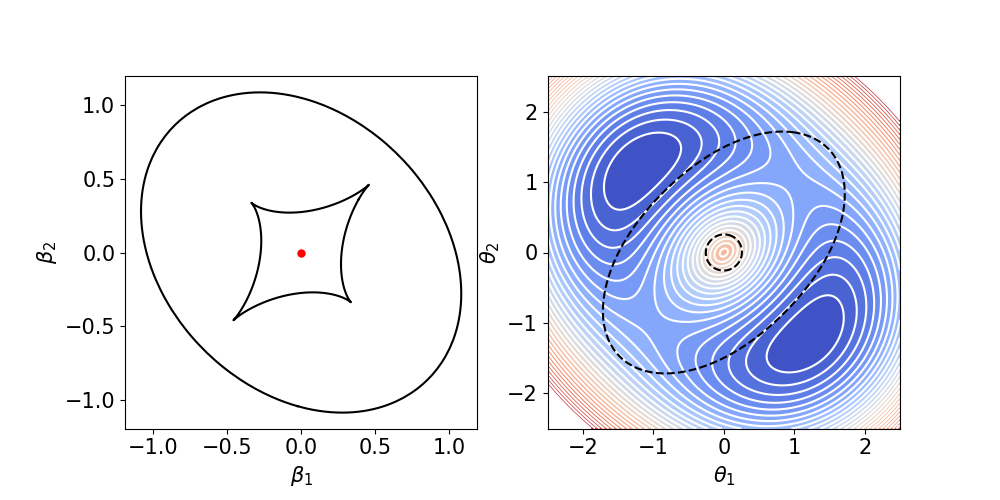

In [11]:
fig,ax =plt.subplots(1,2,figsize=(10,5))

# define some contour levels
max_td = 1.5*((-lens.pot).max()-td.min())

if max_td>0:
    levels = np.linspace(0,max_td,30)
else:
    levels=30

ax[1].contourf(td-td.min(),levels=levels,cmap=cm.coolwarm,extent=[-FOV/2.,FOV/2.,-FOV/2.,FOV/2.])
ax[1].contour(td-td.min(),levels=levels,extent=[-FOV/2.,FOV/2.,-FOV/2.,FOV/2.],colors='white')
for cl in tancl:
    cau = lens.crit2cau(cl)
    thetac2, thetac1 = cl[:,0], cl[:,1]
    betac2, betac1 = cau[:,0], cau[:,1]
    ax[1].plot(thetac1,thetac2,'--',color='black')
    ax[0].plot(betac1,betac2,'-',color='black')

for cl in radcl:
    cau = lens.crit2cau(cl)
    thetac2, thetac1 = cl[:,0], cl[:,1]
    betac2, betac1 = cau[:,0], cau[:,1]
    ax[1].plot(thetac1,thetac2,'--',color='black')
    ax[0].plot(betac1,betac2,'-',color='black')


ax[0].plot(beta1,beta2,'o',ms=5,color='red')

for i in range(2):
    ax[i].set_aspect('equal')
    ax[i].xaxis.set_tick_params(labelsize=fontsize)
    ax[i].yaxis.set_tick_params(labelsize=fontsize)
ax[0].set_xlabel(r'$\beta_1$',fontsize=fontsize)
ax[0].set_ylabel(r'$\beta_2$',fontsize=fontsize)
ax[1].set_xlabel(r'$\theta_1$',fontsize=fontsize)
ax[1].set_ylabel(r'$\theta_2$',fontsize=fontsize)

It is easier to make the plot above a bit more interactive, to allow to quickly see how the time delay surface changes when the source position is different. The class below assembles the different pieces of code discussed above to build an interactive app to display the time delay surfaces:

In [12]:
class td_app(object):

    def __init__(self,co,theta,image=None,**kwargs):

        if image == None:
            # create a plot with two panels only
            self.fig,self.ax =plt.subplots(1,2,figsize=(10,5))
            fontsize = 15

            lens = sie(co,**kwargs)
            lens.setGrid(theta=theta)
            tancl = lens.tancl()
            radcl = lens.radcl()

            beta1 = 0.0
            beta2 = 0.0

            self.update_td_plot(beta1,beta2,lens,tancl,radcl)

            self.cid = self.fig.canvas.mpl_connect('button_press_event', self.mouse_event)
            for i in range(2):
                self.ax[i].set_aspect('equal')
                self.ax[i].xaxis.set_tick_params(labelsize=fontsize)
                self.ax[i].yaxis.set_tick_params(labelsize=fontsize)
            self.ax[0].set_xlabel(r'$\beta_1$',fontsize=fontsize)
            self.ax[0].set_ylabel(r'$\beta_2$',fontsize=fontsize)
            self.ax[1].set_xlabel(r'$\theta_1$',fontsize=fontsize)
            self.ax[1].set_ylabel(r'$\theta_2$',fontsize=fontsize)
            plt.tight_layout()
        else:
            self.fig,self.ax =plt.subplots(1,3,figsize=(12,5))
            fontsize = 15
            lens = sie(co,**kwargs)
            lens.setGrid(theta=theta)
            tancl = lens.tancl()
            radcl = lens.radcl()

            beta1 = 0.0
            beta2 = 0.0

            self.update_td_plot(beta1,beta2,lens,tancl,radcl)

            self.cid = self.fig.canvas.mpl_connect('button_press_event', self.mouse_event)

            self.ax[2].imshow(image)
            for i in range(2):
                self.ax[i].set_aspect('equal')
                self.ax[i].xaxis.set_tick_params(labelsize=fontsize)
                self.ax[i].yaxis.set_tick_params(labelsize=fontsize)
            self.ax[0].set_xlabel(r'$\beta_1$',fontsize=fontsize)
            self.ax[0].set_ylabel(r'$\beta_2$',fontsize=fontsize)
            self.ax[1].set_xlabel(r'$\theta_1$',fontsize=fontsize)
            self.ax[1].set_ylabel(r'$\theta_2$',fontsize=fontsize)
            plt.tight_layout()

            


    def mouse_event(self,event):
        #print('x: {} and y: {}'.format(event.xdata, event.ydata))
        if event.inaxes not in [self.ax[0]]:
            print ("Not a clickable region!")
            return

        self.ax[0].clear()
        self.ax[1].clear()
        self.update_td_plot(event.xdata,event.ydata,lens,tancl,radcl)

    def update_td_plot(self,beta1, beta2,lens,tancl,radcl):

        geomtd = self.geom_tdelay_(lens.theta1,lens.theta2,beta1=beta1,beta2=beta2)
        gravtd = - lens.pot

        FOV= lens.theta1.max()-lens.theta1.min()


        td  = (geomtd + gravtd)*lens.conv_fact_time.value

        # define some contour levels
        max_td = 1.5*((-lens.pot).max()-td.min())

        if max_td>0:
            levels = np.linspace(0,max_td,30)
        else:
            levels=30

        self.ax[1].contourf(td-td.min(),levels=levels,cmap=cm.coolwarm,extent=[-FOV/2.,FOV/2.,-FOV/2.,FOV/2.])
        self.ax[1].contour(td-td.min(),levels=levels,extent=[-FOV/2.,FOV/2.,-FOV/2.,FOV/2.],colors='white')
        for cl in tancl:
            cau = lens.crit2cau(cl)
            thetac2, thetac1 = cl[:,0], cl[:,1]
            betac2, betac1 = cau[:,0], cau[:,1]
            self.ax[1].plot(thetac1,thetac2,'--',color='black')
            self.ax[0].plot(betac1,betac2,'-',color='black')

        for cl in radcl:
            cau = lens.crit2cau(cl)
            thetac2, thetac1 = cl[:,0], cl[:,1]
            betac2, betac1 = cau[:,0], cau[:,1]
            self.ax[1].plot(thetac1,thetac2,'--',color='black')
            self.ax[0].plot(betac1,betac2,'-',color='black')

        self.ax[0].plot(beta1,beta2,'o',ms=5,color='red')

    def geom_tdelay_(self,theta1,theta2,beta1=0.0,beta2=0.0):
        """
        Function to calculate the geometrical time delay:
        inputs: 
        - theta1, theta2 :: mesh of coordinates where the time delay will be evaluated
        - beta1, beta2 :: unlensed source coordinates
        output: 
        - geometrical time delay surface  
        """
        return (0.5*((theta1-beta1)**2+(theta2-beta2)**2))

In the example below, click with your mouse on any position on the left panel to see how the map in the right panel changes on the fly.

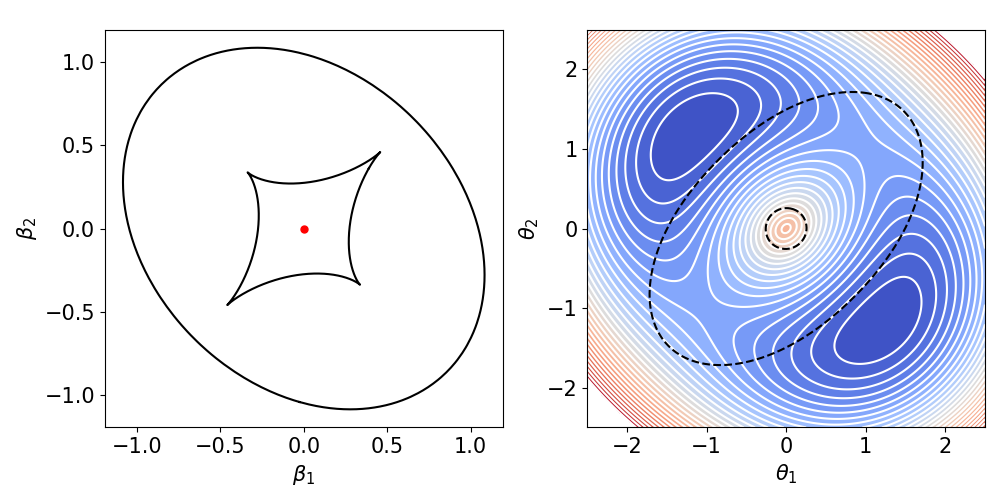

In [13]:
td_app(co,theta,**kwargs)

## Final test

The source images form at the stationary points of the time delay surface. With this in mind, and using the app you just built, it should be easy for you to figure out what is the time delay surface of a particular gravitational lens system. 

>**TASK**: Try to reproduce the time delay surface of the three gravitational lensing events in the right panels. You can assume that the side length of each lens image is 5 arcsec. This number is arbitrary, but at the moment you are not trying to reproduce the lens size, only the shape of the time delay surface. For the same reason, you may assume $z_L=0.5$ and $z_S=2.0$ for all lens systems. If you want, you can google the lens name and gather some more information on sizes and redshifts. Perhaps, you'll be able to reproduce also the scale of the lens systems.

### G2237+0305

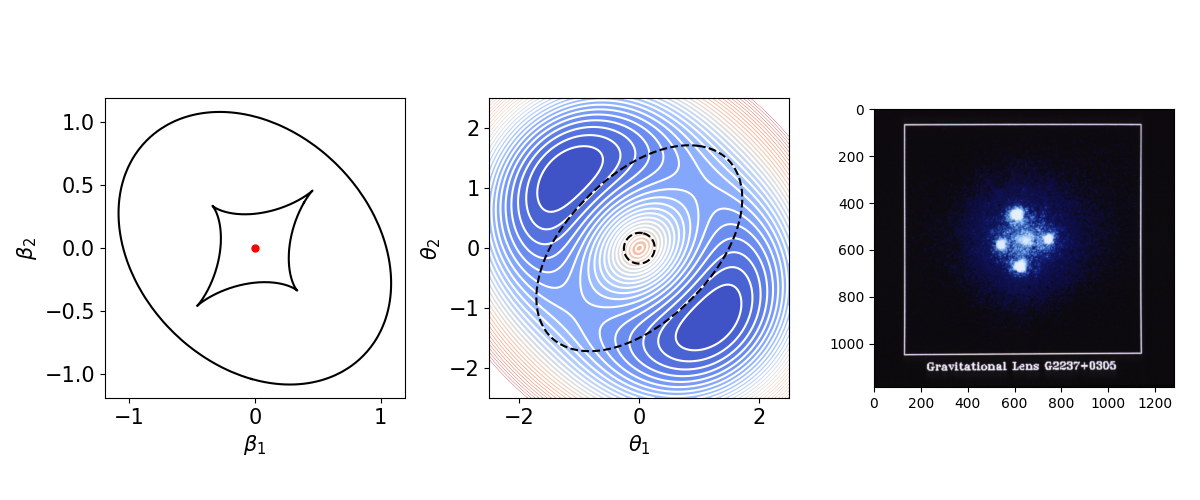

In [14]:
from PIL import Image
im = Image.open('./data/G2237+0305.jpeg')

# DON'T CHANGE THESE PARAMETERS (UNLESS YOU WANT TO GATHER MORE INFOS ABOUT THE LENS)
FOV = 5.0 # the Field-of-View will be FOVxFOV arcsec 
npix= 512 # the number of pixels in the maps will be (npix x npix)

theta = np.linspace(-FOV/2., FOV/2, npix)

zl = 0.5
zs = 2.0

# MODIFY THE LENS PARAMETERS AS NEEDED
kwargs = {'zl': zl,
          'zs': zs,
          'sigma0': 300.0,
          'q': 0.6,
          'pa': np.pi/4.0,
          'theta_c': 0.05,
          'x1': 0.0,
          'x2': 0.0}

td_app(co,theta,image=im,**kwargs)

### MS2137 (image system A)

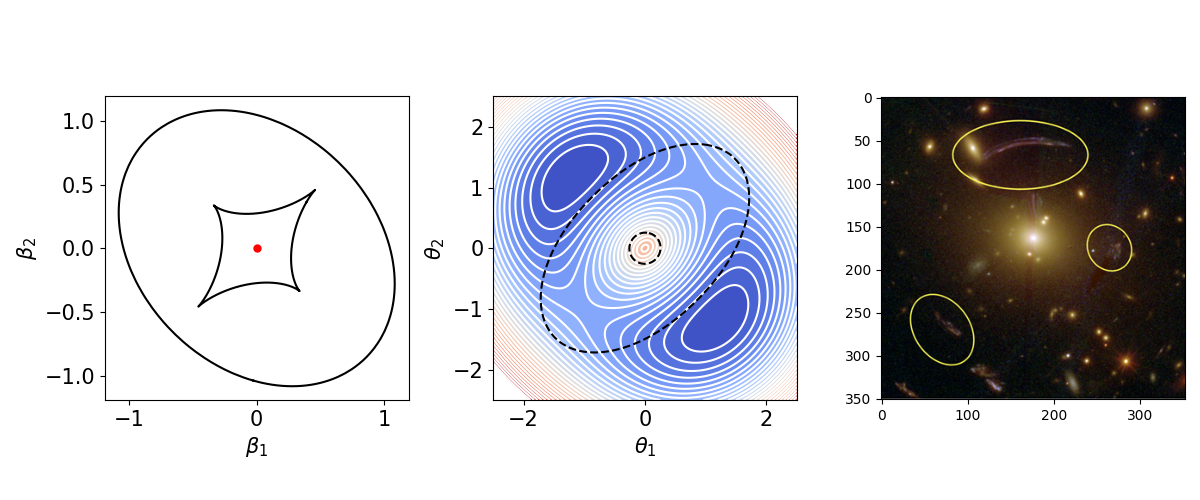

In [15]:
from PIL import Image
im = Image.open('./data/MS2137_crop.png')

# DON'T CHANGE THESE PARAMETERS (UNLESS YOU WANT TO GATHER MORE INFOS ABOUT THE LENS)
FOV = 5.0 # the Field-of-View will be FOVxFOV arcsec 
npix= 512 # the number of pixels in the maps will be (npix x npix)

theta = np.linspace(-FOV/2., FOV/2, npix)

zl = 0.5
zs = 2.0

# MODIFY THE LENS PARAMETERS AS NEEDED
kwargs = {'zl': zl,
          'zs': zs,
          'sigma0': 300.0,
          'q': 0.6,
          'pa': np.pi/4.0,
          'theta_c': 0.05,
          'x1': 0.0,
          'x2': 0.0}

td_app(co,theta,image=im,**kwargs)

### MS2137 (image system B)

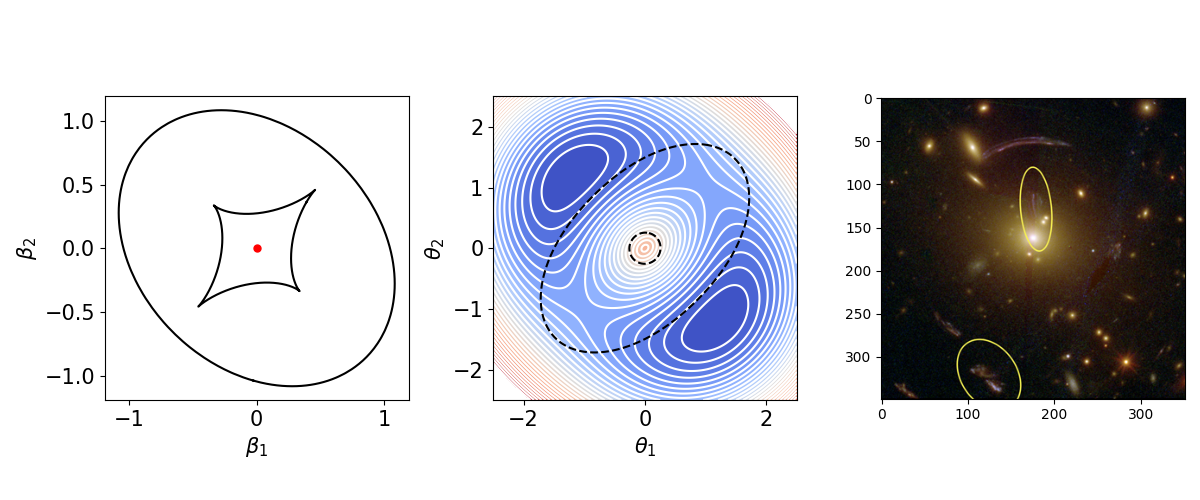

In [16]:
from PIL import Image
im = Image.open('./data/MS2137b.png')

# DON'T CHANGE THESE PARAMETERS (UNLESS YOU WANT TO GATHER MORE INFOS ABOUT THE LENS)
FOV = 5.0 # the Field-of-View will be FOVxFOV arcsec 
npix= 512 # the number of pixels in the maps will be (npix x npix)

theta = np.linspace(-FOV/2., FOV/2, npix)

zl = 0.5
zs = 2.0

# MODIFY THE LENS PARAMETERS AS NEEDED
kwargs = {'zl': zl,
          'zs': zs,
          'sigma0': 300.0,
          'q': 0.6,
          'pa': np.pi/4.0,
          'theta_c': 0.05,
          'x1': 0.0,
          'x2': 0.0}

td_app(co,theta,image=im,**kwargs)